In [166]:
# https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning/
# Bayesian Optimization(BO)
# : Grid Search 처럼 모든 경우를 다 계산하는 것이 아니라, 몇개만 계산해서 objective function 의 최대 or 최소가 될 수 있는 hyperparameter 를 찾는 최적화기법

In [167]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
from sklearn.preprocessing import StandardScaler

from tensorflow import keras

from numpy.random import seed # 예측 결과 일정하게 하기 위함
seed(1) # 예측 결과 일정하게 하기 위함
import tensorflow as tf  # 예측 결과 일정하게 하기 위함
tf.random.set_seed(2) # 예측 결과 일정하게 하기 위함


In [168]:
# This code makes accuracy the scorer metric.

score_acc = make_scorer(accuracy_score)

In [169]:
# Loaddata set

data = pd.read_csv("bladder_cancer.csv")
data.head(3)

data = data.dropna()

X = data.drop(columns=['Label'], axis=1)
y = data['Label']

In [170]:
# train_set with cross-validation : test_set = 80 : 20 

train_feature, test_feature, train_label, test_label = train_test_split(X, y, test_size = 0.2,random_state=0)

In [171]:
# feature normalization, label 은 normalization 진행하지 않았음
scaler = StandardScaler() # scaler 객체 생성
scaler.fit(train_feature) # train_feature 의 mean 과 standard deviation 값을 추출
train_feature_scaled = scaler.transform(train_feature) # train_feature 의 정규화 진행
test_feature_scaled = scaler.transform(test_feature) # test_feature 의 정규화 진행.
# test_feature 는 mean 과 standard deviation 값을 추출하는 과정 하면 안됨. 
# 학습할 때와 동일한 기반 설정으로 동일하게 테스트 데이터를 변환되야 함. 

In [172]:
# pandas numpy 로 변환
train_label = np.array(train_label)
test_label = np.array(test_label)

In [173]:
haha = ['A','B','C']
haha[1]

'B'

In [174]:
# Create function
def nn_cl_bo2(neurons_first_hidden,neurons_inter_hidden, neurons_last_hidden, learning_rate, batch_size, epochs,
              inter_hidden_number):
   
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    neurons_first_hidden = round(neurons_first_hidden)
    neurons_inter_hidden = round(neurons_inter_hidden)
    neurons_last_hidden = round(neurons_last_hidden)
    batch_size = round(batch_size)
    epochs = round(epochs)
    
    inter_hidden_number = round(inter_hidden_number)
    
    def nn_cl_fun():
        nn = Sequential()
        nn.add(Dense(neurons_first_hidden, input_dim=10, activation='relu'))
        for i in range(inter_hidden_number):
            nn.add(Dense(neurons_inter_hidden, activation='relu'))
        nn.add(Dense(neurons_last_hidden, activation='relu'))
        nn.add(Dense(1, activation='sigmoid'))
        nn.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return nn
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=50)
    nn = KerasClassifier(build_fn=nn_cl_fun, epochs=epochs, batch_size=batch_size, verbose=0)
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(nn, train_feature_scaled, train_label, scoring=score_acc, cv=kfold, fit_params={'callbacks':[es]}).mean()
    return score

In [175]:
# The following code searches for the optimum hyperparameters and layers for the Neural Network model
params_nn2 ={
    'neurons_first_hidden': (10,50),
    'neurons_inter_hidden':(50,150),
    'neurons_last_hidden':(10,50),
    'learning_rate':(0.00005, 0.001),
    'batch_size':(10, 100),
    'epochs':(50, 500),
    'inter_hidden_number':(1,6),
}
# Run Bayesian Optimization
# 'normalization':(0,1), # 이건 사용 안함

nn_bo = BayesianOptimization(nn_cl_bo2, params_nn2, random_state=111)
nn_bo.maximize(init_points=10, n_iter=10)

|   iter    |  target   | batch_... |  epochs   | inter_... | learni... | neuron... | neuron... | neuron... |
-------------------------------------------------------------------------------------------------------------
2/2 [==============================] - 0s 1ms/step
|  1        |  0.8671   |  65.1     |  126.1    |  3.18     |  0.000780 |  21.81    |  64.92    |  10.9     |
2/2 [==============================] - 0s 1ms/step
|  2        |  0.8188   |  47.82    |  157.4    |  2.688    |  0.000991 |  19.51    |  58.12    |  36.78    |
2/2 [==============================] - 0s 998us/step
|  3        |  0.8137   |  65.91    |  173.4    |  3.331    |  0.000162 |  12.96    |  140.1    |  41.76    |
2/2 [==============================] - 0s 2ms/step
|  4        |  0.8242   |  85.65    |  416.8    |  5.955    |  0.000598 |  42.55    |  92.13    |  11.1     |
2/2 [==============================] - 0s 2ms/step
|  5        |  0.8403   |  50.87    |  97.4     |  5.086    |  0.000712 |  32.61   

In [176]:
# Fitting Neural Network
params_nn_ = nn_bo.max['params']
learning_rate = params_nn_['learning_rate']
params_nn_['batch_size'] = round(params_nn_['batch_size'])
params_nn_['epochs'] = round(params_nn_['epochs'])
params_nn_['inter_hidden_number'] = round(params_nn_['inter_hidden_number'])
params_nn_['neurons_first_hidden'] = round(params_nn_['neurons_first_hidden'])
params_nn_['neurons_inter_hidden'] = round(params_nn_['neurons_inter_hidden'])
params_nn_['neurons_last_hidden'] = round(params_nn_['neurons_last_hidden'])
params_nn_

{'batch_size': 15,
 'epochs': 108,
 'inter_hidden_number': 1,
 'learning_rate': 0.0002651000377795583,
 'neurons_first_hidden': 32,
 'neurons_inter_hidden': 68,
 'neurons_last_hidden': 17}

In [177]:
def nn_cl_fun_2():
    nn_2 = Sequential()
    nn_2.add(Dense(params_nn_['neurons_first_hidden'], input_dim=10, activation='relu'))
    for i in range(params_nn_['inter_hidden_number']):
        nn_2.add(Dense(params_nn_['neurons_inter_hidden'], activation='relu'))
    nn_2.add(Dense(params_nn_['neurons_last_hidden'], activation='relu'))
    nn_2.add(Dense(1, activation='sigmoid'))
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    nn_2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return nn_2

nn_2 = KerasClassifier(build_fn=nn_cl_fun_2, epochs=params_nn_['epochs'], batch_size=params_nn_['batch_size'],
                         verbose=0)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracy=[]

for train_index, validation_index in kfold.split(train_feature_scaled,train_label):
    history = nn_2.fit(train_feature_scaled[train_index], train_label[train_index]
            ,validation_data=(train_feature_scaled[validation_index],train_label[validation_index])
            ,callbacks=EarlyStopping(monitor='val_loss',patience=50)
            )



    accuracy_history = history.history['accuracy'] # training data accuracy
    val_accuracy_history = history.history['val_accuracy'] # validation data accuracy
    loss_history = history.history['loss'] # training data loss
    val_loss_history = history.history['val_loss'] # training data loss

    k_accuracy = str(nn_2.score(train_feature_scaled[validation_index],train_label[validation_index]))
    accuracy.append([k_accuracy, accuracy_history,val_accuracy_history, loss_history, val_loss_history])

In [178]:
nn_2.score(test_feature_scaled, test_label)

0.9166666865348816

In [179]:
# accuracy

In [180]:
# val_accuracy_history

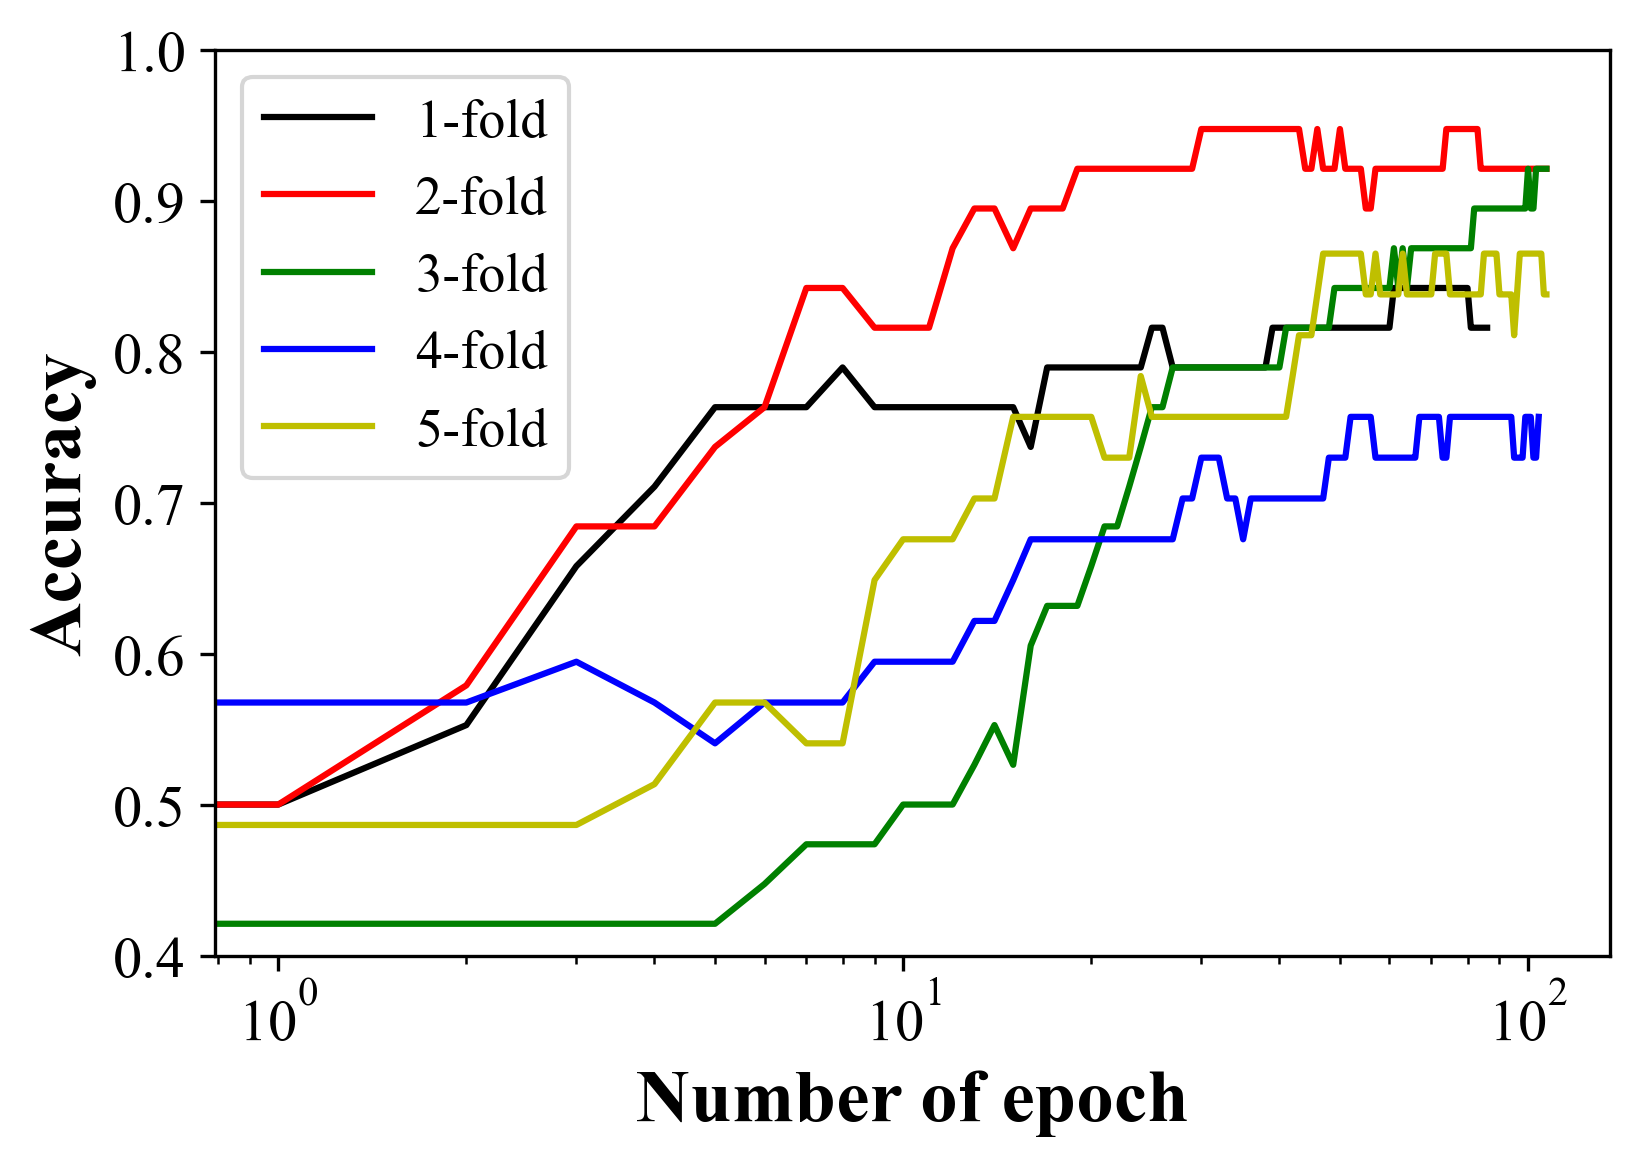

In [181]:
## Visualize history
import matplotlib.pyplot as plt

# set Times New Roman as global font
from matplotlib import font_manager, rc
from matplotlib.font_manager import FontProperties

font_path = "C:/Windows/Fonts/times.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

fig = plt.figure(1)
ax = plt.axes()

font = FontProperties()
font.set_name('Times New Roman')
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

plt.rcParams['figure.dpi'] = 300

ax.set_xlabel('Number of epoch', fontsize=18, fontdict=dict(weight='bold'))
plt.xscale("log")
ax.set_ylabel('Accuracy', fontsize=18, fontdict=dict(weight='bold'))


colours = 'krgby'
for i in range(5):
  # plt.plot(accuracy[i][1],marker='.',c=colours[i],label=str(i+1)+"-fold")
  plt.plot(accuracy[i][2],c=colours[i], label=str(i+1)+"-fold") # 각각의 fold 마다 accuracy 출력

plt.ylim(0.4,1.0)
plt.legend(fontsize=13)
plt.grid(False)



#plt.title('Prediction accuracy using validation dataset with respect to epochs at each fold')